# NYC 311 Mini‑Project — Missing Data • Regex • Visualization • Pandas/Numpy
**Class day:** 2025-10-17

You will explore a recent slice of NYC 311 service requests (last 1,000 rows). Your goals:

- Practice the *data science process*: posing questions → wrangling/cleaning → analysis → communicating.
- Use tools such as **missing‑data handling**, **regex**, **Pandas/Numpy**, and **visualization**.
- Produce **one figure** answering the guided question and **one figure** answering your own question.


## 1) Setup & Load Data


In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import re
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", 120)

df = pd.read_csv('erm2-nwe9.csv')
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,66464514,2025-10-14T01:51:17.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10466.0,655 EAST 230 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.891872,-73.860168,"\n, \n(40.89187241649303, -73.86016845296459)"
1,66465967,2025-10-14T01:51:14.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11212.0,181 ROCKAWAY PARKWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662317,-73.921442,"\n, \n(40.66231674694474, -73.92144177201318)"
2,66470344,2025-10-14T01:50:47.000,NaN,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,11436.0,137-32 132 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.669856,-73.800419,"\n, \n(40.6698558316466, -73.80041885315545)"
3,66464521,2025-10-14T01:50:42.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Television,Residential Building/House,10458.0,2980 VALENTINE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.871881,-73.886143,"\n, \n(40.87188118407785, -73.88614285307307)"
4,66470365,2025-10-14T01:50:33.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10466.0,655 EAST 230 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.891872,-73.860168,"\n, \n(40.89187241649303, -73.86016845296459)"


## 2) Explore the Data

You can learn more about the dataset [here](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data)

Explore the data to understand its structure and content. Consider the following questions:
- What are the key columns in the dataset?
- What types of data are present (numerical, categorical, text, etc.)?
- What are the distributions of key variables?
- Are there any missing values or anomalies in the data?

Here is some starter code to help look at missingness that you can copy and paste in a code cell::

```python
missing = df.isna().mean().sort_values(ascending=False)
print("Share missing (top 20):")
display(missing.head(20).to_frame("share_missing"))
```

> `df['column_name'].value_counts()` can be useful for exploring categorical variables.

In [5]:
missing = df.isna().mean().sort_values(ascending=False)
print("Share missing (top 20):")
display(missing.head(20).to_frame("share_missing"))

df.info()



Share missing (top 20):


,share_missing
taxi_company_borough,1.000
facility_type,1.000
road_ramp,0.999
due_date,0.997
bridge_highway_direction,0.995
taxi_pick_up_location,0.995
bridge_highway_name,0.991
bridge_highway_segment,0.991
vehicle_type,0.964
closed_date,0.464


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      1000 non-null   int64  
 1   created_date                    1000 non-null   object 
 2   closed_date                     536 non-null    object 
 3   agency                          1000 non-null   object 
 4   agency_name                     1000 non-null   object 
 5   complaint_type                  1000 non-null   object 
 6   descriptor                      979 non-null    object 
 7   location_type                   968 non-null    object 
 8   incident_zip                    990 non-null    float64
 9   incident_address                980 non-null    object 
 10  street_name                     980 non-null    object 
 11  cross_street_1                  815 non-null    object 
 12  cross_street_2                  816

## 3) What Keywords in resolution_description are Associated with Longer Resolution Times?

You will need to compute the resolution time for each request. You can do this by calculating the difference between the `closed_date` and `created_date` columns using code like this:
```python
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')
df["resolution_time_hours"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 3600.0
```

Think about how you will handle missing values in your analysis since some requests may not have a `closed_date`.

Top 20 keywords associated with longer resolution times:
inspected: 2.69 hours
party: 2.69 hours
reinspection: 2.69 hours
done: 2.69 hours
within: 2.69 hours
days: 2.69 hours
if: 2.69 hours
still: 2.69 hours
exists: 2.69 hours
second: 2.69 hours
some: 2.69 hours
cases: 2.69 hours
make: 2.69 hours
repairs: 2.69 hours
charge: 2.69 hours
costs: 2.69 hours
be: 1.88 hours
transportation: 1.79 hours
responsible: 1.63 hours
will: 1.60 hours


/var/folders/f4/ftsj1j7n5837rlz4_q0rks500000gn/T/ipykernel_40517/3903829530.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['resolution_text_clean'] = df_clean['resolution_description'].apply(preprocess_text)
/var/folders/f4/ftsj1j7n5837rlz4_q0rks500000gn/T/ipykernel_40517/3903829530.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_resolution_hours', y='keyword', data=plot_df, palette='viridis')


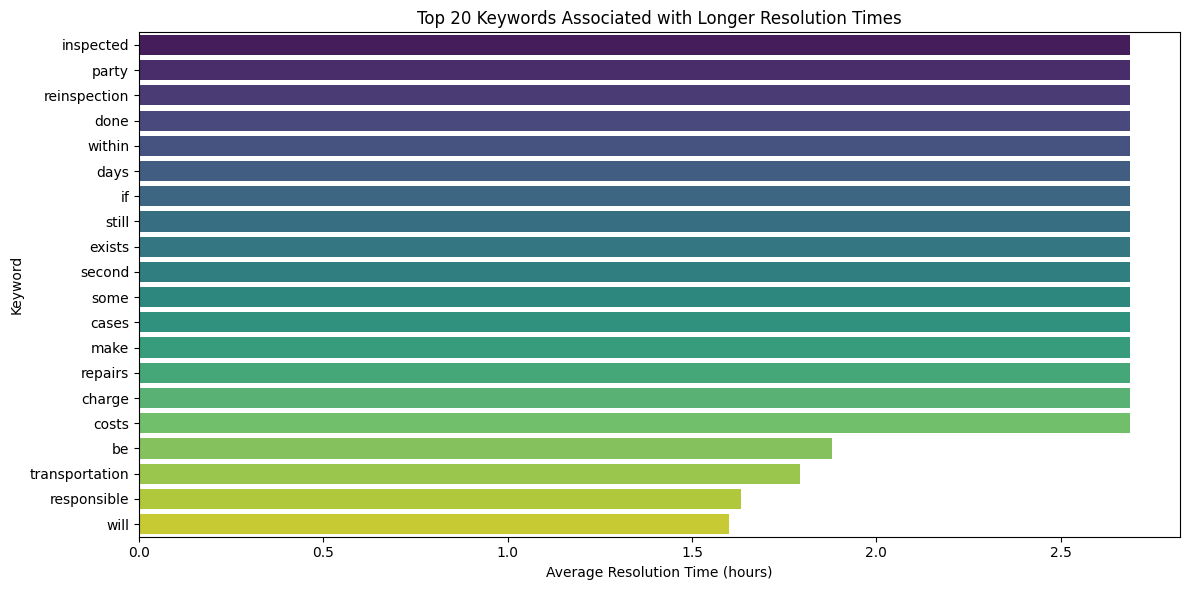

In [12]:
# --- 1. Convert dates and compute resolution time ---
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

# Compute resolution time in hours
df['resolution_time_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600.0

# Drop rows where resolution_time_hours is missing (i.e., no closed_date)
df_clean = df.dropna(subset=['resolution_time_hours', 'resolution_description'])

# --- 2. Preprocess text (basic cleaning) ---
def preprocess_text(text):
    text = str(text).lower()                   # lowercase
    text = re.sub(r'[^a-z\s]', '', text)      # remove punctuation and numbers
    return text

df_clean['resolution_text_clean'] = df_clean['resolution_description'].apply(preprocess_text)

# --- 3. Tokenize and count words ---
# Create a Counter to store total resolution time and counts per word
word_times = {}
word_counts = {}

for idx, row in df_clean.iterrows():
    words = row['resolution_text_clean'].split()
    for word in words:
        if word not in word_times:
            word_times[word] = 0
            word_counts[word] = 0
        word_times[word] += row['resolution_time_hours']
        word_counts[word] += 1

# Compute average resolution time per word
avg_resolution_time_per_word = {word: word_times[word]/word_counts[word] for word in word_times}

# Sort by longest average resolution time
sorted_words = sorted(avg_resolution_time_per_word.items(), key=lambda x: x[1], reverse=True)

# --- 4. Show top 20 keywords associated with long resolution times ---
print("Top 20 keywords associated with longer resolution times:")
for word, avg_time in sorted_words[:20]:
    print(f"{word}: {avg_time:.2f} hours")

# --- 5. Visualize the results ---
# --- Take the top 20 keywords from previous analysis ---
top_n = 20
top_words = sorted_words[:top_n]

# Prepare data for plotting
words, avg_times = zip(*top_words)
plot_df = pd.DataFrame({'keyword': words, 'avg_resolution_hours': avg_times})

# --- Plot ---
plt.figure(figsize=(12,6))
sns.barplot(x='avg_resolution_hours', y='keyword', data=plot_df, palette='viridis')
plt.xlabel('Average Resolution Time (hours)')
plt.ylabel('Keyword')
plt.title(f'Top {top_n} Keywords Associated with Longer Resolution Times')
plt.tight_layout()
plt.show()

## 4) Pick another question to explore

Make sure to create a figure to answer your question!

**Ideas to help you come up with your own.**
- Are there certain locations that take longer to resolve issues?
- Are there specific types of complaints that are more common in certain areas?
- Are open cases different in nature from closed cases?

Average resolution times by location type:


,avg_resolution_time_hours
location_type,
Street,2.689167
Street/Sidewalk,1.075268
Store/Commercial,0.988389
Club/Bar/Restaurant,0.689198
Common Area,0.675556
Park/Playground,0.551151
Subway,0.487698
Residential Building/House,0.394992


/var/folders/f4/ftsj1j7n5837rlz4_q0rks500000gn/T/ipykernel_40517/247184378.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_avg_times.values, y=location_avg_times.index, palette='magma')


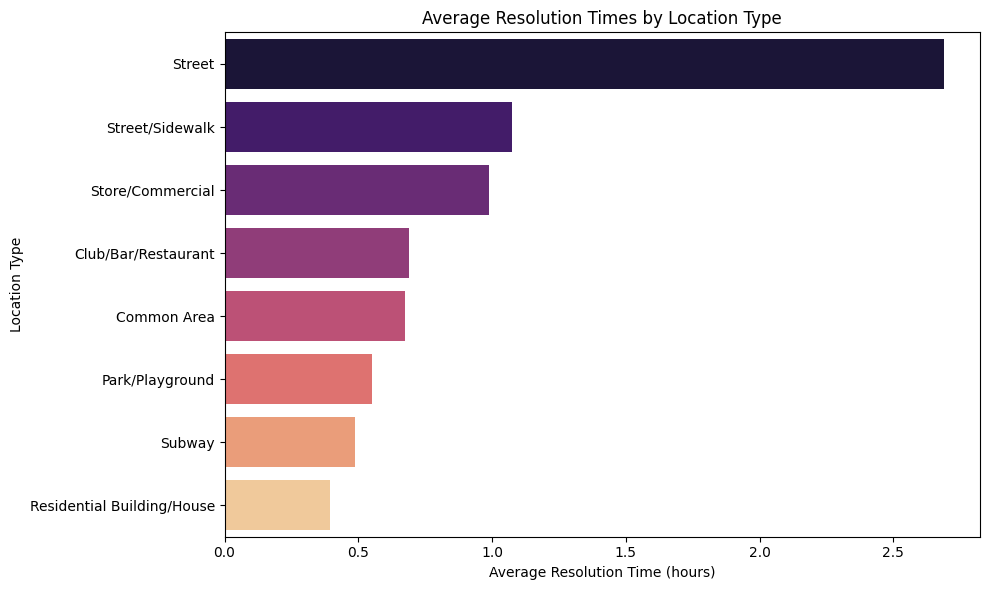

In [ ]:
# Are there certain location types that take longer to resolve issues?

# --- Analyze resolution times by location ---
# Group by location_type and compute average resolution time
location_avg_times = df_clean.groupby('location_type')['resolution_time_hours'].mean().sort_values(ascending=False)
print("Average resolution times by location type:")
display(location_avg_times.to_frame("avg_resolution_time_hours"))

# --- Visualize average resolution times by location type ---
plt.figure(figsize=(10,6))
sns.barplot(x=location_avg_times.values, y=location_avg_times.index, palette='magma')
plt.xlabel('Average Resolution Time (hours)')
plt.ylabel('Location Type')
plt.title('Average Resolution Times by Location Type')
plt.tight_layout()
plt.show()
